In [170]:
from matplotlib import font_manager, rc  # 한글사용 matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import csv
import codecs
import numpy as np
import json
import tensorflow as tf
import jpype
from konlpy.tag import Okt
from IPython.core.interactiveshell import InteractiveShell
from pandas import DataFrame as df
InteractiveShell.ast_node_interactivity = 'all'
os.chdir("C:/Users/windd/pythondata")
%matplotlib inline
font_name = font_manager.FontProperties(
    fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [172]:
rdata = pd.read_csv('bigcontest/2019빅콘테스트_퓨처스리그2/AFSNT.csv',engine='python',encoding='cp949')

# 변수통일

rdata["STT"] = pd.to_datetime(rdata["STT"], format = "%H:%M").dt.time
rdata["ATT"] = pd.to_datetime(rdata["ATT"], format = "%H:%M").dt.time

rdata = rdata.rename(columns={ 
   "SDT_YY": "year", "SDT_MM":"month", "SDT_DD":"day",  "SDT_DY":"wday", 
    "ARP":"origin", "ODP":"dest", 
    "FLO":"airline", "FLT":"flight" ,"REG":"tailnum", 
    "AOD":"is_arrive", 
    "IRR":"is_regular", 
    "STT":"sched_time", "ATT":"real_time", 
    "DLY":"is_delay", "DRR":"cause_delay", 
    "CNL":"is_cancel", "CNR":"cause_cancel"
})
rdata["date"] = pd.to_datetime(rdata[["year", "month", "day"]])
rdata["sched_datetime"] = pd.to_datetime(rdata['date'].astype(str) + " " + rdata["sched_time"].astype(str))
rdata["real_datetime"] = pd.to_datetime(rdata['date'].astype(str) + " " + rdata["real_time"].astype(str))

# delay 변수 생성
temp = rdata["real_datetime"] - rdata["sched_datetime"] 
temp = pd.DataFrame(temp.dt.components)
rdata["delay"] = temp['minutes'] + 60 * temp['hours'] + 1440 * temp['days']
del temp

rdata.head()

In [174]:
# 지연 여부 코딩

dly = []
for i in rdata.DLY:
    if i =='Y':
        dly.append(1)
    elif i =='N':
        dly.append(0)
rdata['DLY2'] = dly

In [176]:
yy = rdata.SDT_YY
mm = rdata.SDT_MM
dd = rdata.SDT_DD

# 날짜 병합 함수
from datetime import datetime

def time_merge(year,month,day):
    date = []
    for i in range(len(year)):
        date_str = str(year[i])+'-'+str(month[i])+'-'+str(day[i])
        date_date = datetime.strptime(date_str,'%Y-%m-%d')
        date.append(date_date)
    return date
a = time_merge(yy,mm,dd)

rdata['DATE'] = a

In [178]:
# 결항데이터 제거

rdata2 =rdata[~(rdata['CNL']=='Y')]
rdata2 = rdata2[~(rdata2.REG.isnull())]
rdata2.isnull().sum()
len(rdata2)

SDT_YY         0
SDT_MM         0
SDT_DD         0
SDT_DY         0
ARP            0
ODP            0
FLO            0
FLT            0
REG            0
AOD            0
IRR            0
STT            0
ATT            0
DLY            0
DRR       860509
CNL            0
CNR       979446
DLY2           0
DATE           0
dtype: int64

979446

In [180]:
rdata3 = rdata2[['DATE','FLO','FLT','REG','ARP','ODP','AOD','IRR','DLY','STT','ATT','DLY2']]
rdata3 = rdata3.sort_values(by=['FLT','DATE'])

In [182]:
rdata_sorted = rdata3.sort_values(by=['DATE','FLO','FLT','REG'])
rdata_sorted.index = list(range(len(rdata_sorted)))
len(rdata_sorted)

979446

In [184]:
rdata_sorted.index = list(range(len(rdata_sorted)))

# 시간 범주화 함수 정의
def time_dicrete(stt):
    time_dic = []
    for i in range(len(stt)):
        st = int(stt[i].split(':')[0])*60 + int(stt[i].split(':')[1])
        if st >= 300 and st < 480:
            time_dic.append('5시-8시')
        elif st >= 480 and st < 660:
            time_dic.append('8시-11시')
        elif st >= 660 and st < 840:
            time_dic.append('11시-14시')
        elif st >= 840 and st < 1020:
            time_dic.append('14시-17시')
        elif st >= 1020 and st < 1200:
            time_dic.append('17시-20시')
        elif st >= 1200 and st < 1380:
            time_dic.append('20시-23시')
        elif st >=1380 or st<300:
            time_dic.append('23시-3시')
    return time_dic  

stt = list(rdata_sorted.STT)

a = time_dicrete(stt)

In [186]:
# 실제시각, 스케줄 시간 차이 계산 함수 정의

def time_difference(att,stt):
    time_dif = []
    for i in range(len(att)):
        at = int(att[i].split(':')[0])*60 + int(att[i].split(':')[1])
        st = int(stt[i].split(':')[0])*60 + int(stt[i].split(':')[1])
        time_dif.append(at-st)
    return time_dif

In [188]:
att = rdata_sorted.ATT
stt = rdata_sorted.STT

time_dif = time_difference(att,stt)

In [190]:
# 시간범주화, 시간차이 변수 추가

rdata_sorted['T_DISC'] = a
rdata_sorted['DIF'] = time_dif

In [192]:
# 일단 지연인데 시간차가 -로 많이 나는것들.. 일단은 그냥 지우고 시작 
# 지우는게 맞는거 같음

rdata_sorted[((rdata_sorted['DIF']<30) & (rdata_sorted['DLY2']==1))]
rdata_sorted = rdata_sorted[~((rdata_sorted['DIF']<30) & (rdata_sorted['DLY2']==1))]
len(rdata_sorted)

,DATE,FLO,FLT,REG,ARP,ODP,AOD,IRR,DLY,STT,ATT,DLY2,DIR,T_DISC,DIF
406103,2018-01-11,J,J1257,SEw3NzE5,ARP1,ARP3,A,N,Y,16:35,1:43,1,2018-01-11 00:00:00J1257SEw3NzE5,14시-17시,-892
406104,2018-01-11,J,J1257,SEw3NzE5,ARP3,ARP1,D,N,Y,15:25,0:56,1,2018-01-11 00:00:00J1257SEw3NzE5,14시-17시,-869
540840,2018-05-18,L,L1735,SEw4MjM1,ARP3,ARP1,A,N,Y,23:26,0:28,1,2018-05-18 00:00:00L1735SEw4MjM1,23시-3시,-1378


979443

# 현재는 출도착 맞지 않는 쌍에 대해서 맞는 것만 진행
# 안 맞는 것도 포함해서 진행햇음

In [194]:
a = rdata_sorted.pivot_table(index=['DATE','FLT','REG'],aggfunc='count',values='STT')
len(a[a['STT']==1])
len(a[a['STT']==2])
len(a[a['STT']==3])
len(a[a['STT']==4])

2767

488319

2

8

In [196]:
go1 = a[a['STT']==1]
go1.reset_index(['DATE','FLT','REG'],inplace=True)
go2 = a[a['STT']==2]
go2.reset_index(['DATE','FLT','REG'],inplace=True)
go3 = a[a['STT']==3]
go3.reset_index(['DATE','FLT','REG'],inplace=True)
go4 = a[a['STT']==4]
go4.reset_index(['DATE','FLT','REG'],inplace=True)

In [198]:
go1_list =[]
for i in range(len(go1)):
    go1_list.append(str(go1.DATE[i])+str(go1.FLT[i])+str(go1.REG[i]))
    
go2_list = []
for i in range(len(go2)):
    go2_list.append(str(go2.DATE[i])+str(go2.FLT[i])+str(go2.REG[i]))
    
go3_list = []
for i in range(len(go3)):
    go3_list.append(str(go3.DATE[i])+str(go3.FLT[i])+str(go3.REG[i]))
    
go4_list = []
for i in range(len(go4)):
    go4_list.append(str(go4.DATE[i])+str(go4.FLT[i])+str(go4.REG[i]))

In [200]:
r_list = []
rdata_sorted.index = list(range(len(rdata_sorted)))
for i in range(len(rdata_sorted)):
    r_list.append(str(rdata_sorted.DATE[i])+str(rdata_sorted.FLT[i])+str(rdata_sorted.REG[i]))
rdata_sorted['DIR'] = r_list

In [202]:
rdata_go1 = rdata_sorted[rdata_sorted.DIR.isin(go1_list)]
rdata_go2 =  rdata_sorted[rdata_sorted.DIR.isin(go2_list)]
rdata_go3 =  rdata_sorted[rdata_sorted.DIR.isin(go3_list)]
rdata_go4 =  rdata_sorted[rdata_sorted.DIR.isin(go4_list)]

len(rdata_go1) + len(rdata_go2) + len(rdata_go3) +len(rdata_go4)
len(rdata_sorted)

979443

979443

In [204]:
rdata_sorted_2 = rdata_go2.sort_values(['DATE','FLO','FLT','REG'])
rdata_sorted_2.drop('DIR', axis = 1, inplace = True)

In [206]:
# 4가지로 나눠서 본 것인데, 어쨋든 현재 A,D의 수가 맞지 않는다.
# 제거하거나 전처리 필요

rdata_go1.pivot_table(index='AOD',aggfunc='count',values='DLY2')
rdata_go2.pivot_table(index='AOD',aggfunc='count',values='DLY2')
rdata_go3.pivot_table(index='AOD',aggfunc='count',values='DLY2')
rdata_go4.pivot_table(index='AOD',aggfunc='count',values='DLY2')

len(rdata_sorted)

,DLY2
AOD,
A,1525
D,1242


,DLY2
AOD,
A,488319
D,488319


,DLY2
AOD,
A,4
D,2


,DLY2
AOD,
A,16
D,16


979443

In [208]:
# 생키다이어그램을 위한 전처리를 위해서 D만 생각한다.

rdata_d = rdata_sorted_2[rdata_sorted_2['AOD']=='D'].sort_values(['DATE','REG'])

In [210]:
# 항공기의 스케줄 시간을 수치화시키는 함수 정의
# 이를 통해 시간에 따라서 정렬할 수 있다.


rdata_d.index = list(range(len(rdata_d)))

def time(stt):
    time_dic = []
    for i in range(len(stt)):
        st = int(stt[i].split(':')[0])*60 + int(stt[i].split(':')[1])
        time_dic.append(st)
    return time_dic
time_dic = time(rdata_d.STT)

In [211]:
rdata_d['STT2'] = time_dic

In [212]:
# 날짜, 등록기호, 출발시간으로 보면 연결되었다는 것을 알 수 있다.
# 같은 날짜, 같은 등록기호에 대해서 시간순으로 보가 떄문에 

rdata_d = rdata_d.sort_values(['DATE','REG','STT2'])
rdata_d.index = list(range(len(rdata_d)))
rdata_d

,DATE,FLO,FLT,REG,ARP,ODP,AOD,IRR,DLY,STT,ATT,DLY2,T_DISC,DIF,STT2
0,2017-01-01,A,A1981,SEw3MjQ3,ARP1,ARP3,D,N,N,7:20,7:30,0,5시-8시,10,440
1,2017-01-01,A,A1954,SEw3MjQ3,ARP3,ARP1,D,N,Y,9:15,10:04,1,8시-11시,49,555
2,2017-01-01,A,A1983,SEw3MjQ3,ARP1,ARP3,D,N,Y,11:05,11:55,1,11시-14시,50,665
3,2017-01-01,A,A1984,SEw3MjQ3,ARP3,ARP1,D,N,Y,13:00,13:40,1,11시-14시,40,780
4,2017-01-01,A,A1985,SEw3MjQ3,ARP1,ARP3,D,N,Y,14:50,15:49,1,14시-17시,59,890
5,2017-01-01,A,A1934,SEw3MjQ3,ARP3,ARP1,D,N,Y,16:45,17:45,1,14시-17시,60,1005
6,2017-01-01,A,A1937,SEw3MjQ3,ARP1,ARP3,D,N,Y,18:35,19:38,1,17시-20시,63,1115
7,2017-01-01,A,A1978,SEw3MjQ3,ARP3,ARP1,D,N,Y,20:40,21:42,1,20시-23시,62,1240
8,2017-01-01,J,J1216,SEw3NDYw,ARP1,ARP3,D,N,N,9:55,10:13,0,8시-11시,18,595
9,2017-01-01,J,J1217,SEw3NDYw,ARP3,ARP1,D,N,N,12:10,12:25,0,11시-14시,15,730


In [213]:
# 출도착 같은 거 제거
# 공항1 -> 공항1 로 가는 데이터 있었음

rdata_d = rdata_d[~((rdata_d['ARP']=='ARP1') & (rdata_d['ODP']=='ARP1'))]
rdata_d = rdata_d.sort_values(['DATE','REG','STT2'])
rdata_d.index = list(range(len(rdata_d)))

In [214]:
# 전처리 이해 예제
# x는 하나의 등록기호가 하루의 얼마나 운행하는지 알 수 있고
# 하루에 운행된 것은 연결되었다고 판단
# y는 일별로 구분해야되기 때문에 하루에 운행하는 횟수를 리스트로 만들었다
# y를 참조해서 하루에 운행한 것들을 표현

x = rdata_d[rdata_d['REG']=='SEw3NzE4'][['DATE','REG','ARP','ODP','STT2']]
x = x.sort_values(['DATE','STT2'])
x.index = list(range(len(x)))
list1 = list(x.ARP+','+ x.ODP)
y = x.pivot_table(index='DATE',aggfunc='count',values='REG')
y = y.reset_index()
x

,DATE,REG,ARP,ODP,STT2
0,2017-01-01,SEw3NzE4,ARP6,ARP3,510
1,2017-01-01,SEw3NzE4,ARP3,ARP6,605
2,2017-01-01,SEw3NzE4,ARP6,ARP3,705
3,2017-01-01,SEw3NzE4,ARP3,ARP6,805
4,2017-01-01,SEw3NzE4,ARP6,ARP3,910
5,2017-01-01,SEw3NzE4,ARP3,ARP1,1040
6,2017-01-01,SEw3NzE4,ARP1,ARP3,1150
7,2017-01-01,SEw3NzE4,ARP3,ARP1,1255
8,2017-01-02,SEw3NzE4,ARP1,ARP2,540
9,2017-01-02,SEw3NzE4,ARP2,ARP1,630


In [215]:
# 최종적으로 데이터프레임으로 만들면 
# 각 행은 각 날짜에 운행한 것이며
# 열은 링크(엣지)로 생각하면 된다.


a=[]
b=0
qq= []

for i in range(len(y)):
    
    a = list1[b:y['REG'][i]+b]
    b += len(a)
    qq.append(a)

In [216]:
df = pd.DataFrame(qq)
df

,0,1,2,3,4,5,6,7,8,9
0,"ARP6,ARP3","ARP3,ARP6","ARP6,ARP3","ARP3,ARP6","ARP6,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None
1,"ARP1,ARP2","ARP2,ARP1","ARP1,ARP3","ARP3,ARP2",None,None,None,None,None,None
2,"ARP2,ARP3","ARP3,ARP2",None,None,None,None,None,None,None,None
3,"ARP2,ARP3","ARP3,ARP2","ARP2,ARP15","ARP15,ARP2",None,None,None,None,None,None
4,"ARP2,ARP1","ARP1,ARP3",None,None,None,None,None,None,None,None
5,"ARP3,ARP1","ARP1,ARP3","ARP3,ARP6","ARP6,ARP3","ARP3,ARP8","ARP8,ARP3","ARP3,ARP1",None,None,None
6,"ARP1,ARP3","ARP3,ARP8","ARP8,ARP3","ARP3,ARP1","ARP1,ARP2","ARP2,ARP3","ARP3,ARP2",None,None,None
7,"ARP2,ARP3","ARP3,ARP4","ARP4,ARP3","ARP3,ARP13","ARP13,ARP3","ARP3,ARP4","ARP4,ARP3","ARP3,ARP2",None,None
8,"ARP2,ARP15","ARP15,ARP2","ARP2,ARP3","ARP3,ARP2",None,None,None,None,None,None
9,"ARP2,ARP3","ARP3,ARP4","ARP4,ARP3","ARP3,ARP2","ARP2,ARP3","ARP3,ARP1",None,None,None,None


In [217]:
# 전처리 진행, 

rdata_d = rdata_d.sort_values(['DATE','REG','STT2'])
rdata_d.index = list(range(len(rdata_d)))
reg_list = list(rdata_d.REG.unique())
rdata_ddd = rdata_d[['DATE','REG','ARP','ODP','STT2']]

ex = []
for i in reg_list:
    x = rdata_ddd[rdata_ddd['REG']== i][['DATE','REG','ARP','ODP','STT2']]
    x = x.sort_values(['DATE','STT2'])
    x.index = list(range(len(x)))
    list1 = list(x.ARP+','+x.ODP)
    y = x.pivot_table(index='DATE',aggfunc='count',values='REG')
    y = y.reset_index()
    a = []
    qq = []
    b= 0 
    for j in range(len(y)):
        a = list1[b: y['REG'][j]+b]
        b += len(a)
        qq.append(a)
    ex.append(qq)

In [218]:
ss = sum(ex,[])
pdpd = pd.DataFrame(ss)
pdpd

,0,1,2,3,4,5,6,7,8,9,10
0,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
1,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
2,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
3,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
4,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
5,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
6,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
7,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
8,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None
9,"ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1","ARP1,ARP3","ARP3,ARP1",None,None,None


In [219]:
# 개수 맞음

a = 0
for i in range(11):
    a += pdpd[i].value_counts().sum()
a

len(rdata_ddd)

488314

488314

In [220]:
link_table = pd.DataFrame()

In [221]:
idx = pdpd[0].value_counts()
idx

ARP1,ARP3     28438
ARP2,ARP3     14400
ARP3,ARP1      6818
ARP2,ARP1      6613
ARP1,ARP2      3814
ARP2,ARP15     3793
ARP6,ARP3      3479
ARP4,ARP3      3454
ARP15,ARP2     2858
ARP7,ARP3      1543
ARP1,ARP5      1498
ARP3,ARP6      1451
ARP15,ARP4     1303
ARP3,ARP2      1087
ARP4,ARP15      906
ARP1,ARP12      874
ARP1,ARP9       845
ARP1,ARP4       669
ARP3,ARP8       634
ARP1,ARP11      597
ARP4,ARP1       587
ARP1,ARP8       579
ARP5,ARP1       416
ARP3,ARP4       342
ARP8,ARP3       242
ARP3,ARP13      173
ARP3,ARP9       172
ARP3,ARP12      127
ARP14,ARP3       45
ARP3,ARP5        42
ARP5,ARP3        33
ARP3,ARP7        32
ARP2,ARP4        29
ARP3,ARP15       28
ARP4,ARP2        26
ARP15,ARP3       17
ARP6,ARP1        12
ARP3,ARP14       12
ARP1,ARP6        11
ARP1,ARP7         6
ARP6,ARP2         5
ARP12,ARP1        5
ARP7,ARP8         5
ARP8,ARP1         4
ARP6,ARP4         4
ARP7,ARP2         3
ARP7,ARP1         3
ARP1,ARP14        2
ARP13,ARP1        2
ARP5,ARP15        1


In [222]:
출발노드 = []
도착노드 = []
링크 = []
횟수 = []
for i in range(len(idx)):
    split_list = idx.index[i].split(',')
    출발노드.append(split_list[0])
    도착노드.append(split_list[1])
    링크.append(0)
    횟수.append(idx[i])

In [223]:
link_table['출발노드'] = 출발노드
link_table['도착노드'] = 도착노드
link_table['링크'] = 링크
link_table['횟수'] = 횟수
link_table

,출발노드,도착노드,링크,횟수
0,ARP1,ARP3,0,28438
1,ARP2,ARP3,0,14400
2,ARP3,ARP1,0,6818
3,ARP2,ARP1,0,6613
4,ARP1,ARP2,0,3814
5,ARP2,ARP15,0,3793
6,ARP6,ARP3,0,3479
7,ARP4,ARP3,0,3454
8,ARP15,ARP2,0,2858
9,ARP7,ARP3,0,1543


In [224]:
# 각 열은 링크 수준에서 (0, 1, 2 등) 출발공항에서 도착공항으로 몇 회 운행했는지 파악 가능

link_table = pd.DataFrame()
출발노드 = []
도착노드 = []
링크 = []
횟수 = []

for i in range(11):
    idx = pdpd[i].value_counts()

    for j in range(len(idx)):
        split_list = idx.index[j].split(',')
        출발노드.append(split_list[0])
        도착노드.append(split_list[1])
        링크.append(i)
        횟수.append(idx[j])

link_table['출발노드'] = 출발노드
link_table['도착노드'] = 도착노드
link_table['링크'] = 링크
link_table['횟수'] = 횟수

In [225]:
link_table2 = link_table.sort_values(by=['출발노드','도착노드'])
link_table2

,출발노드,도착노드,링크,횟수
152,ARP1,ARP10,2,1
19,ARP1,ARP11,0,597
83,ARP1,ARP11,1,288
138,ARP1,ARP11,2,41
181,ARP1,ARP11,3,69
218,ARP1,ARP11,4,466
266,ARP1,ARP11,5,189
314,ARP1,ARP11,6,58
15,ARP1,ARP12,0,874
93,ARP1,ARP12,1,30


In [226]:
link_table2.pivot_table(index=['출발노드','도착노드'],aggfunc='sum',values='횟수')

횟수
출발노드  도착노드         
ARP1  ARP10       1
      ARP11    1708
      ARP12    1768
      ARP13       1
      ARP14       2
      ARP15       1
      ARP2    25705
      ARP3   111492
      ARP4      681
      ARP5     6126
      ARP6       21
      ARP7        9
      ARP8     1917
      ARP9     3747
ARP10 ARP1        2
      ARP2        1
ARP11 ARP1     1708
ARP12 ARP1     1771
      ARP3      607
ARP13 ARP1        3
      ARP3     2050
ARP14 ARP3      910
ARP15 ARP2     4912
      ARP3       17
      ARP4     1750
      ARP7        1
ARP2  ARP1    26540
      ARP15    4916
      ARP3    28545
      ARP4       42
...             ...
ARP3  ARP5     1840
      ARP6    17091
      ARP7     1548
      ARP8    14534
      ARP9     2517
ARP4  ARP1      701
      ARP15    1749
      ARP2       38
      ARP3    14186
      ARP6        4
ARP5  ARP1     6120
      ARP15       2
      ARP2        1
      ARP3     1841
ARP6  ARP1       23
      ARP15       1
      ARP2        8
      ARP3    17100
      ARP4        4
ARP7  ARP1        5
      ARP2        3
      ARP3     1550
      ARP8        5
ARP8  ARP1     1925
      ARP2        1
      ARP3    14523
      ARP7        5
ARP9  ARP1     3750
      ARP3     2517
      ARP6        1

[72 rows x 1 columns]

In [227]:
rdata_d.pivot_table(index=['ARP','ODP'],aggfunc='count',values='DLY2')


DLY2
ARP   ODP          
ARP1  ARP10       1
      ARP11    1708
      ARP12    1768
      ARP13       1
      ARP14       2
      ARP15       1
      ARP2    25705
      ARP3   111492
      ARP4      681
      ARP5     6126
      ARP6       21
      ARP7        9
      ARP8     1917
      ARP9     3747
ARP10 ARP1        2
      ARP2        1
ARP11 ARP1     1708
ARP12 ARP1     1771
      ARP3      607
ARP13 ARP1        3
      ARP3     2050
ARP14 ARP3      910
ARP15 ARP2     4912
      ARP3       17
      ARP4     1750
      ARP7        1
ARP2  ARP1    26540
      ARP15    4916
      ARP3    28545
      ARP4       42
...             ...
ARP3  ARP5     1840
      ARP6    17091
      ARP7     1548
      ARP8    14534
      ARP9     2517
ARP4  ARP1      701
      ARP15    1749
      ARP2       38
      ARP3    14186
      ARP6        4
ARP5  ARP1     6120
      ARP15       2
      ARP2        1
      ARP3     1841
ARP6  ARP1       23
      ARP15       1
      ARP2        8
      ARP3    17100
      ARP4        4
ARP7  ARP1        5
      ARP2        3
      ARP3     1550
      ARP8        5
ARP8  ARP1     1925
      ARP2        1
      ARP3    14523
      ARP7        5
ARP9  ARP1     3750
      ARP3     2517
      ARP6        1

[72 rows x 1 columns]

In [228]:
# 중심성 분석 함수
# 가중치 고려

def get_degree_centrality(df,arp) :
    N = 15
    Z = df[(df['출발노드']==arp)|(df['도착노드']==arp)].횟수.sum()
    D = Z/(N-1)
    return D

In [229]:
# 중심성 분석 

arp_list = list(link_table2['출발노드'].unique())
center_link = pd.DataFrame(data=arp_list,columns=['공항'])
D_list = []

for i in arp_list:
    D = get_degree_centrality(link_table2, i)
    D_list.append(D)

center_link['중심성'] = D_list

center_link.sort_values('중심성',ascending = False)

,공항,중심성
8,ARP3,27901.714286
0,ARP1,21861.571429
7,ARP2,8582.142857
11,ARP6,2446.928571
9,ARP4,2382.142857
13,ARP8,2350.785714
10,ARP5,1138.142857
6,ARP15,969.714286
14,ARP9,895.214286
3,ARP12,339.714286


In [230]:
# 가중치 고려 x

def degree_centrality(df,arp):
    a = df[df['출발노드']==arp]
    D = len((a['출발노드']+','+a['도착노드']).unique())/(N-1)
    return D

In [231]:
N =15
arp_list = list(link_table2['출발노드'].unique())
center= pd.DataFrame(data=arp_list,columns=['공항'])
D_list = []

for i in arp_list:
    D = degree_centrality(link_table2, i)
    D_list.append(D)
    
center['중심성'] = D_list
center

,공항,중심성
0,ARP1,1.000000
1,ARP10,0.142857
2,ARP11,0.071429
3,ARP12,0.142857
4,ARP13,0.142857
5,ARP14,0.071429
6,ARP15,0.285714
7,ARP2,0.642857
8,ARP3,0.857143
9,ARP4,0.357143


# 지연네트워크 분석

In [232]:
rdata_d = rdata_d[rdata_d['DLY2']==1]

rdata_d = rdata_d.sort_values(['DATE','REG','STT2'])
rdata_d.index = list(range(len(rdata_d)))
reg_list = list(rdata_d.REG.unique())
rdata_ddd = rdata_d[['DATE','REG','ARP','ODP','STT2']]

ex = []
for i in reg_list:
    x = rdata_ddd[rdata_ddd['REG']== i][['DATE','REG','ARP','ODP','STT2']]
    x = x.sort_values(['DATE','STT2'])
    x.index = list(range(len(x)))
    list1 = list(x.ARP+','+x.ODP)
    y = x.pivot_table(index='DATE',aggfunc='count',values='REG')
    y = y.reset_index()
    a = []
    qq = []
    b= 0 
    for j in range(len(y)):
        a = list1[b: y['REG'][j]+b]
        b += len(a)
        qq.append(a)
    ex.append(qq)

In [233]:
ss = sum(ex,[])
pdpd = pd.DataFrame(ss)

In [234]:
# 개수 맞음

a = 0
for i in range(10):
    a += pdpd[i].value_counts().sum()
a

len(rdata_ddd)

85630

85630

In [235]:
link_table = pd.DataFrame()
출발노드 = []
도착노드 = []
링크 = []
횟수 = []

for i in range(10):
    idx = pdpd[i].value_counts()

    for j in range(len(idx)):
        split_list = idx.index[j].split(',')
        출발노드.append(split_list[0])
        도착노드.append(split_list[1])
        링크.append(i)
        횟수.append(idx[j])

link_table['출발노드'] = 출발노드
link_table['도착노드'] = 도착노드
link_table['링크'] = 링크
link_table['횟수'] = 횟수

In [236]:
link_table2 = link_table.sort_values(by=['출발노드','도착노드'])
link_table2

,출발노드,도착노드,링크,횟수
26,ARP1,ARP11,0,67
90,ARP1,ARP11,1,23
130,ARP1,ARP11,2,15
172,ARP1,ARP11,3,7
210,ARP1,ARP11,4,6
22,ARP1,ARP12,0,104
89,ARP1,ARP12,1,25
129,ARP1,ARP12,2,15
174,ARP1,ARP12,3,5
211,ARP1,ARP12,4,6


In [237]:
# 중심성 분석 

arp_list = list(link_table2['출발노드'].unique())
center_link_dly = pd.DataFrame(data=arp_list,columns=['공항'])
D_list = []

for i in arp_list:
    D = get_degree_centrality(link_table2, i)
    D_list.append(D)

center_link_dly['중심성'] = D_list

center_link_dly.sort_values('중심성',ascending = False)

,공항,중심성
8,ARP3,5327.714286
0,ARP1,3729.428571
7,ARP2,1399.857143
11,ARP6,457.142857
13,ARP8,428.428571
9,ARP4,386.142857
6,ARP15,148.928571
14,ARP9,99.071429
10,ARP5,90.071429
4,ARP13,69.000000


In [238]:
# 가중치 고려x

N =15
arp_list = list(link_table2['출발노드'].unique())
center_dly= pd.DataFrame(data=arp_list,columns=['공항'])
D_list = []

for i in arp_list:
    D = degree_centrality(link_table2, i)
    D_list.append(D)
    
center_dly['중심성'] = D_list
center_dly

,공항,중심성
0,ARP1,0.714286
1,ARP10,0.071429
2,ARP11,0.071429
3,ARP12,0.142857
4,ARP13,0.142857
5,ARP14,0.071429
6,ARP15,0.285714
7,ARP2,0.642857
8,ARP3,0.857143
9,ARP4,0.285714


In [239]:
# 공항별 운항횟수 및 랭킹

In [240]:
# 각 공항별 운항횟수

arp_count = rdata3.pivot_table(index='ARP',aggfunc='count',values='DLY2')
arp_count.sort_values('DLY2',ascending = False)

,DLY2
ARP,
ARP3,390868
ARP1,307892
ARP2,120636
ARP6,34314
ARP4,33461
ARP8,32917
ARP5,15940
ARP15,13618
ARP9,12536


In [241]:
# 공항별 지연랭킹

rdata3_dly = rdata3[rdata3['DLY2']==1]
dly = rdata3_dly.pivot_table(index='ARP',aggfunc='count',values='DLY2')
dly.sort_values('DLY2',ascending = False)

,DLY2
ARP,
ARP3,58693
ARP1,32129
ARP2,12081
ARP6,3979
ARP8,3746
ARP4,3513
ARP15,1719
ARP9,839
ARP5,765


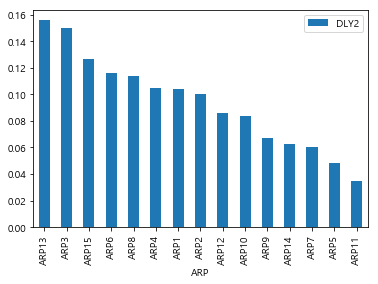

In [242]:
# 공항별 지연랭킹 / 비율

(dly/arp_count).sort_values('DLY2',ascending= False).plot(kind='bar')

# 추가 전처리 필요한 작업 및 슬슬 진행해야할 것

# 전처리 공동 작업 및 공유하여 하나의 파일로 다루기

# 전처리 공동 작업 완료 후 csv로 사용

# 전처리 고려할 것 
# 출발, 도착 공항 같은 경우
# D, A가 쌍으로 존재하지 않는 데이터
# 시간차가 -로 나면서 지연이 된 경우
# 시간차가 -로 나는 값이 매우 큰 경우

In [243]:
# 시간차가 굉장히 많이나는 것들...

rdata_sorted[(rdata_sorted['DIF']<-100)]

,DATE,FLO,FLT,REG,ARP,ODP,AOD,IRR,DLY,STT,ATT,DLY2,DIR,T_DISC,DIF
118500,2017-04-22,J,J1536,SEw3Nzg2,ARP11,ARP1,A,N,N,16:50,7:54,0,2017-04-22 00:00:00J1536SEw3Nzg2,14시-17시,-536
202864,2017-07-07,I,I1558,SEw4MDEy,ARP6,ARP3,A,N,N,18:40,16:43,0,2017-07-07 00:00:00I1558SEw4MDEy,17시-20시,-117
231789,2017-08-02,J,J1612,SEw3NzU4,ARP5,ARP1,A,N,N,13:55,11:08,0,2017-08-02 00:00:00J1612SEw3NzU4,11시-14시,-167
234831,2017-08-05,I,I1584,SEw3Nzg2,ARP6,ARP3,A,N,N,11:50,2:45,0,2017-08-05 00:00:00I1584SEw3Nzg2,11시-14시,-545
299288,2017-10-02,I,I1559,SEw3NTYz,ARP3,ARP6,A,N,N,20:25,0:05,0,2017-10-02 00:00:00I1559SEw3NTYz,20시-23시,-1220
335637,2017-11-04,F,F1706,SEw4MDIz,ARP6,ARP3,A,N,N,22:40,10:37,0,2017-11-04 00:00:00F1706SEw4MDIz,20시-23시,-723
360437,2017-11-27,J,J1959,SEw3NzA0,ARP6,ARP3,A,N,N,17:05,8:12,0,2017-11-27 00:00:00J1959SEw3NzA0,17시-20시,-533
380831,2017-12-17,I,I1558,SEw3Nzg2,ARP6,ARP3,A,N,N,16:15,14:18,0,2017-12-17 00:00:00I1558SEw3Nzg2,14시-17시,-117
401772,2018-01-06,L,L1932,SEw4MDU2,ARP7,ARP3,A,N,N,19:00,6:59,0,2018-01-06 00:00:00L1932SEw4MDU2,17시-20시,-721
406027,2018-01-11,I,I1332,SEw3NTYx,ARP1,ARP3,A,N,N,22:25,2:03,0,2018-01-11 00:00:00I1332SEw3NTYx,20시-23시,-1222


In [244]:
# EDA

In [245]:
rdata3 = rdata2[['DATE','FLO','FLT','REG','ARP','ODP','AOD','IRR','STT','ATT','DLY2','DRR']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


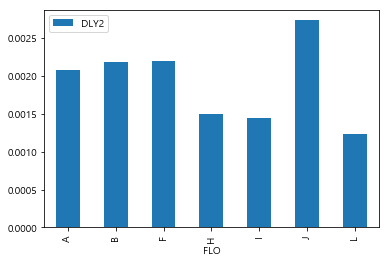

In [246]:
# AC정비 지연에 대해서 각 항공사별로 차이가 있지 않을까?
# 비율로 확인한 것이며 전체 운항에 대해서 AC정비의 비율은 매우 적긴함

a = rdata3[rdata['DRR']=='C01'].pivot_table(index='FLO',aggfunc='count',values='DLY2')/\
rdata3.pivot_table(index='FLO',aggfunc='count',values='DLY2')
a.dropna(axis=0).plot(kind = 'bar')

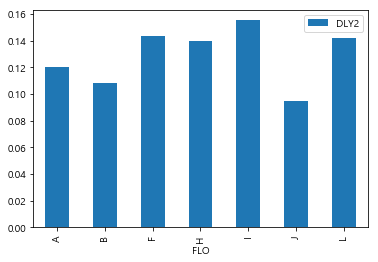

In [247]:
# 항공사에 따른 지연 여부비율

FLO_dly = rdata3[rdata3['DLY2']==1].pivot_table(index='FLO',aggfunc='count',values='DLY2')/\
rdata3.pivot_table(index='FLO',aggfunc='count',values='DLY2')
FLO_dly.dropna(axis=0).plot(kind='bar')

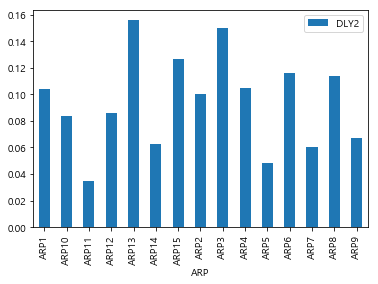

In [248]:
# 출발공항에 따른 지연비율

arp_dly = rdata3[rdata3['DLY2']==1].pivot_table(index='ARP',aggfunc='count',values='DLY2')/\
rdata3.pivot_table(index='ARP',aggfunc='count',values='DLY2')
arp_dly.plot(kind='bar')

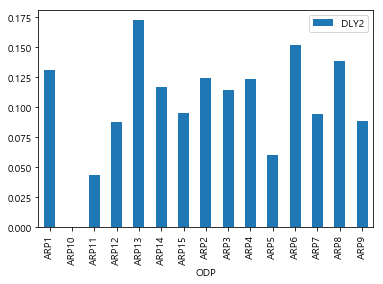

In [249]:
# 도착공항에 따른 지연비율

odp_dly = rdata3[rdata3['DLY2']==1].pivot_table(index='ODP',aggfunc='count',values='DLY2')/\
rdata3.pivot_table(index='ODP',aggfunc='count',values='DLY2')
odp_dly.plot(kind='bar')

# 변수 생성

In [ ]:
# 1 공항별로 지연비율이 차이가 있는 것을 파악했다.
# 공항도 하나의 변수가 될 수 있는데 
# 공항 환경 중 하나인 활주로의 개수가 그 역할을 할 수도 있음
# 공항 추적이 완료되면 추가 조사로 가능해보임

In [ ]:
# 2 출발공항에서 비슷한 시간대에 운항하는 비행기의 수
# 활주로나 혼잡할 수 있기 때문에 지연가능성이 있을 수 있음
# 어떤 기준으로 시간대를 구분할 수 있을지는 더 생각 필요

# 혹은 하루 운행 횟수로 일반화시켜서 보는 것도 가능할수도

In [250]:
rdata3.index = list(range(len(rdata3)))

def time(stt):
    time_dic = []
    for i in range(len(stt)):
        st = int(stt[i].split(':')[0])*60 + int(stt[i].split(':')[1])
        time_dic.append(st)
    return time_dic
time_dic = time(rdata3.STT)
rdata3['STT2'] = time_dic

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [251]:
rdata3_d = rdata3[rdata3['AOD']=='D']
rdata3_d = rdata3_d.sort_values(['DATE','REG','STT2'])
rdata3_d.index = list(range(len(rdata3_d)))

In [252]:
rdata3_d.head()

,DATE,FLO,FLT,REG,ARP,ODP,AOD,IRR,STT,ATT,DLY2,DRR,STT2
0,2017-01-01,A,A1981,SEw3MjQ3,ARP1,ARP3,D,N,7:20,7:30,0,NaN,440
1,2017-01-01,A,A1954,SEw3MjQ3,ARP3,ARP1,D,N,9:15,10:04,1,C01,555
2,2017-01-01,A,A1983,SEw3MjQ3,ARP1,ARP3,D,N,11:05,11:55,1,C02,665
3,2017-01-01,A,A1984,SEw3MjQ3,ARP3,ARP1,D,N,13:00,13:40,1,C02,780
4,2017-01-01,A,A1985,SEw3MjQ3,ARP1,ARP3,D,N,14:50,15:49,1,C02,890


In [253]:
# 예상 출발시간에 대한 값들로 볼 수 있고
# mapping해서 활용할 수 도 있을 거 같다.
# 비슷한 시간대를 잡기가 좀 애매한 거 같긴함

rdata3_d.pivot_table(index=['DATE','ARP','STT'],aggfunc = 'count', values = 'DLY2')

DLY2
DATE       ARP  STT        
2017-01-01 ARP1 10:00     4
                10:10     1
                10:20     1
                10:30     3
                11:00     1
                11:05     1
                11:10     2
                11:25     1
                11:30     2
                11:35     1
                11:40     1
                11:45     1
                12:00     1
                12:10     2
                12:15     1
                12:25     1
                12:30     3
                12:35     1
                12:40     1
                12:45     1
                12:55     2
                13:00     1
                13:05     1
                13:10     3
                13:15     2
                13:20     2
                13:25     2
                13:35     2
                13:40     1
                14:00     2
...                     ...
2019-06-30 ARP6 7:25      1
                7:50      1
                8:20      1
           ARP7 6:20      1
                6:40      1
           ARP8 10:10     1
                10:15     1
                11:00     1
                12:10     1
                12:45     1
                13:25     1
                14:40     1
                14:45     1
                16:45     1
                17:20     1
                18:00     1
                18:30     1
                19:20     1
                19:25     1
                20:40     1
                8:45      1
                9:30      1
                9:55      1
           ARP9 11:45     1
                14:05     1
                16:00     1
                17:05     1
                17:50     1
                19:50     1
                9:10      1

[348917 rows x 1 columns]

In [ ]:
# 3 2번과 마찬가지로 도착공항에서 비슷한 시간대에 도착하는 비행기의 수
# 흐름관리, 혼잡도를 관리하기 위해서 충분히 가능하다고 생각
# 2번과 마찬가지로 구체적으로 시간대의 유사도 기준을 어떻게 잡아야 할지는 논의 필요